# <u> A/B - тестирование в приложении доставки<u> 
    
## Методика тестирования:
Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары. Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 (тестовой) оказались пользователи с новой системой рекомендаций, в группе 0 (контрольной) пользователи со старой версией приложения, где нет рекомендации товаров.
    
## Задача:
Сделать аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех пользователей.

In [23]:
# Импорт библиотек

import pandas as pd
import numpy as np

import pingouin as pg
import scipy.stats as st

import requests
from urllib.parse import urlencode

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
# Общие настройки графики

setting = sns.set(
    font_scale=1.8,
    style="whitegrid",
    rc={'figure.figsize':(15,7)}
        )

In [25]:
# Список соответствия публичных ключей и исходных датафреймов

pb_keys = {
           'df_users_data': 'https://disk.yandex.ru/d/4qY27tJ23G_B1g',
           'df_orders':     'https://disk.yandex.ru/d/prdO8FDQx7lzCg', 
           'df_products':   'https://disk.yandex.ru/d/atwrlmB_wu-fHA'
          }

In [26]:
# Функция загрузки csv-файла по API

def read_yadisk_csv(public_key: str) -> pd.DataFrame():

    base_url  = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response  = requests.get(final_url) 
    download_url = response.json()['href']
    df = pd.read_csv(download_url)
    datetime_columns = [label for label in df.columns if ('time' in label) or ('date' in label)]
    df[datetime_columns] = df[datetime_columns].apply(pd.to_datetime)
    
    return df

## EDA-анализ

Получение основной информации о датафреймах и изучение особенностей данных в них.

### 1. История заказов пользователей (df_users_data)

In [27]:
df_users_data = read_yadisk_csv(pb_keys['df_users_data'])
df_users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1


In [28]:
# Переименуем группы

df_users_data['group'] = np.where(df_users_data.group == 1, 'test', 'control')
df_users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,control
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,test
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,control
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,control
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,test


In [26]:
# Размер df

df_users_data.shape

(4337, 6)

In [27]:
# Пропущенные значения не обнаружены

df_users_data.isna().sum()

user_id     0
order_id    0
action      0
time        0
date        0
group       0
dtype: int64

In [28]:
# Число уникальных пользователей и категорий

df_users_data.nunique()

user_id     1017
order_id    4123
action         2
time        4312
date          14
group          2
dtype: int64

In [29]:
# Полные дубликаты в данных отсутсвуют 

df_users_data.duplicated().sum()

0

In [68]:
# Неуникальные заказы = отмененные заказы

df_users_data[df_users_data[['user_id', 'order_id']].duplicated()].head()

,user_id,order_id,action,time,date,group
8,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,control
39,993,1296,cancel_order,2022-08-26 00:44:18.150475,2022-08-26,control
47,995,1298,cancel_order,2022-08-26 00:49:51.514240,2022-08-26,control
54,1002,1308,cancel_order,2022-08-26 00:58:01.924112,2022-08-26,test
60,1008,1315,cancel_order,2022-08-26 01:06:11.292953,2022-08-26,control


**Примечание:** при подсчете метрик не будем учитывать отмененные заказы

In [44]:
# Отмененные заказы

canceled_orders = df_users_data[df_users_data[['user_id', 'order_id']].duplicated()].order_id

In [45]:
# Основаная информация о фрейме

df_users_data.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4337 entries, 0 to 4336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   4337 non-null   int64         
 1   order_id  4337 non-null   int64         
 2   action    4337 non-null   object        
 3   time      4337 non-null   datetime64[ns]
 4   date      4337 non-null   datetime64[ns]
 5   group     4337 non-null   object        
dtypes: datetime64[ns](2), int64(2), object(2)

### 2. Подробная информация о составе заказа (df_orders)

In [29]:
df_orders = read_yadisk_csv(pb_keys['df_orders'])
df_orders.head(10)

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56,"{74, 6}"
4,1259,2022-08-26 00:03:37,"{20, 45, 67, 26}"
5,1261,2022-08-26 00:05:35,"{30, 35, 69, 6}"
6,1262,2022-08-26 00:06:25,"{23, 69, 45, 33}"
7,1263,2022-08-26 00:08:22,"{22, 23, 5}"
8,1264,2022-08-26 00:10:53,"{60, 5, 33, 69}"
9,1265,2022-08-26 00:11:21,"{19, 35, 74, 42, 25}"


In [34]:
# Размер df

df_orders.shape

(4123, 3)

In [35]:
# Пропущенные значения не обнаружены

df_orders.isna().sum()

order_id         0
creation_time    0
product_ids      0
dtype: int64

In [36]:
# Число уникальных пользователей и категорий

df_orders.nunique()

order_id         4123
creation_time    4098
product_ids      3877
dtype: int64

In [37]:
# Полные дубликаты в данных отсутсвуют 

df_orders.duplicated().sum()

0

In [38]:
# Неуникальные времена создания заказов = заказы созданные в одно время

df_orders[df_orders['creation_time'].duplicated()].head()

,order_id,creation_time,product_ids
48,1310,2022-08-26 00:53:03,"{56, 31, 63}"
71,1340,2022-08-26 01:24:04,"{42, 51, 76, 69, 74}"
164,1455,2022-08-26 05:10:26,"{57, 20, 32}"
355,1678,2022-08-26 09:38:22,"{15, 58, 74}"
382,1709,2022-08-26 10:04:06,"{22, 62, 24, 16}"


In [39]:
df_orders[df_orders.creation_time == '2022-08-26 00:53:03']

,order_id,creation_time,product_ids
47,1311,2022-08-26 00:53:03,"{63, 32}"
48,1310,2022-08-26 00:53:03,"{56, 31, 63}"


In [40]:
# Основаная информация о фрейме

df_orders.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       4123 non-null   int64         
 1   creation_time  4123 non-null   datetime64[ns]
 2   product_ids    4123 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(1)

### 3. Подробная информация о продуктах (df_products)

In [30]:
df_products = read_yadisk_csv(pb_keys['df_products'])
df_products.head(10)

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0
5,6,сухарики,25.0
6,7,кофе зерновой,350.8
7,8,сушки,30.4
8,9,чай черный листовой,83.5
9,10,семечки,12.0


In [189]:
# Размер df

df_products.shape

(87, 3)

In [190]:
# Пропущенные значения не обнаружены

df_products.isna().sum()

product_id    0
name          0
price         0
dtype: int64

In [191]:
# Число уникальных пользователей и категорий

df_products.nunique()

product_id    87
name          87
price         63
dtype: int64

In [192]:
# Полные дубликаты в данных отсутсвуют 

df_products.duplicated().sum()

0

In [193]:
# Основная информация о фрейме

df_products.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product_id  87 non-null     int64  
 1   name        87 non-null     object 
 2   price       87 non-null     float64
dtypes: float64(1), int64(1), object(1)

# <u> Анализ результатов A/B - тестирования<u>

### 1. Доля отмененных заказов
    
Предположим, что новая система рекомендаций положительно влияет на пользовательский опыт использования приложения. Для проверки этой гипотезы посмотрим на долю отмененных заказов в группах. Имеются две категориальные переменные → **воспользуемся критерием хи-квадрат**

- $H_0$: доли отмененных заказов в группах равны
- $H_1$: доли отмененных заказов в группах не равны

In [31]:
df_users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,control
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,test
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,control
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,control
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,test


In [32]:
# Создадим таблицу сопряженности 

pd.crosstab(df_users_data.group, df_users_data.action)

action,cancel_order,create_order
group,,
control,82,1609
test,132,2514


In [33]:
# Хи-квадрат тест независимости переменных в таблице сопряженности (без поправки Йетса)

stat, p, dof, expected  = st.chi2_contingency(pd.crosstab(df_users_data.group, df_users_data.action), correction=False)

In [34]:
# Статистика и p-value

stat, p

(0.04277579068025318, 0.8361480225696976)

In [35]:
# Доля отмененных заказов

part_canceled = df_users_data \
                    .groupby('group') \
                    .apply(lambda x: x[x.action == 'cancel_order'][['action']].count() / x.shape[0]) \
                    .rename(columns={'action': 'orders'}) \
                    .mul(100) \
                    .round(2) \
                    .reset_index()
part_canceled

,group,orders
0,control,4.85
1,test,4.99


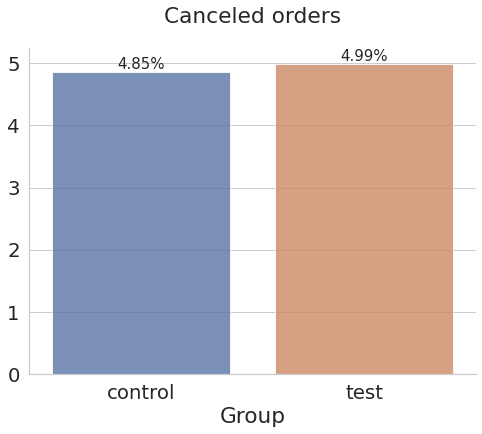

In [231]:
# Визуализация долей отмененных заказов в группах

plt.figure(figsize=(8, 6))
ax = sns.barplot(data=part_canceled, x='group', y='orders', alpha=0.8)
ax.set(xlabel='Group', ylabel='')
ax.set_title('Canceled orders', pad=25)

for p in ax.patches:
    percentage = '{:.2f}%'.format(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=15)
sns.despine()
plt.show()

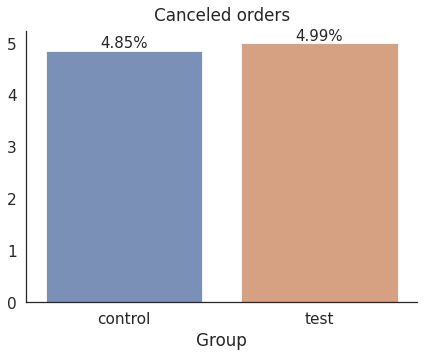

In [50]:
# Визуализация долей отмененных заказов в группах

plt.figure(figsize=(7, 5))
sns.set(style='white', font_scale=1.4)
ax = sns.barplot(data=part_canceled, x='group', y='orders', alpha=0.8)
ax.set(xlabel='Group', ylabel='')
ax.set_title('Canceled orders', pad=10)

for p in ax.patches:
    percentage = '{:.2f}%'.format(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=15)
sns.despine()
plt.show()

### Вывод №1:

Результаты теста не позволяют нам отклонить нулевую гипотезу (H0), следовательно, мы не можем утверждать, что новая система рекомендаций товаров приводит к изменению доли отмененных заказов.

### 2. Количество заказов на пользователя

Предположим, что новая система рекомендаций товаров может стимулировать покупателей делать больше заказов т.к. она лучше чем старая понимает потребности и интересы конкретного пользователя.

In [46]:
df_count_orders = df_users_data \
    .query("order_id not in @canceled_orders") \
    .groupby(['user_id', 'group'], as_index=False) \
    .agg({'order_id':'count'})
df_count_orders

,user_id,group,order_id
0,964,control,2
1,965,test,9
2,967,test,5
3,968,control,3
4,969,control,2
...,...,...,...
1008,1976,test,5
1009,1977,test,4
1010,1978,test,6
1011,1979,test,5


**Примечание:** при подсчете метрики не учитываются отмененные заказы

In [47]:
# Размер выборки тестовой и контрольной групп

df_count_orders.group.value_counts()

control    512
test       501
Name: group, dtype: int64

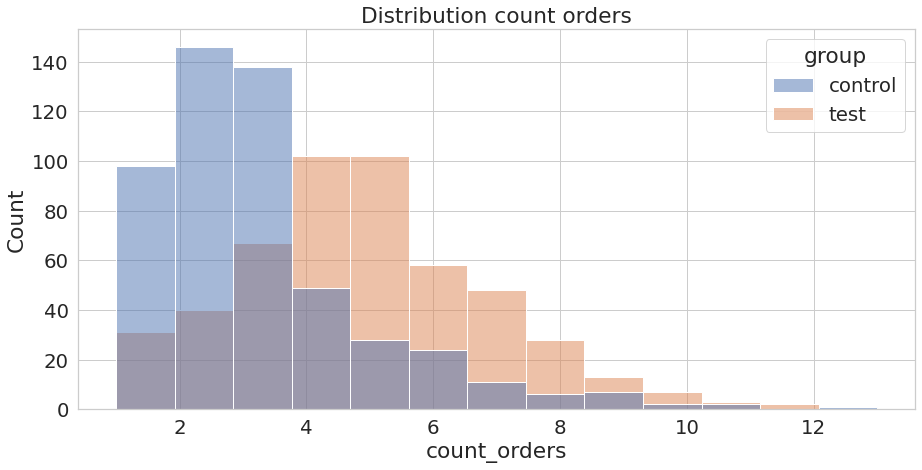

In [62]:
# Визуализация распределения количества заказов на пользователя

plt.figure(figsize=(15, 7))
ax = sns.histplot(data=df_count_orders, x='order_id', hue='group', bins=13)
ax.set(title='Distribution count orders', xlabel='count_orders')
plt.show()

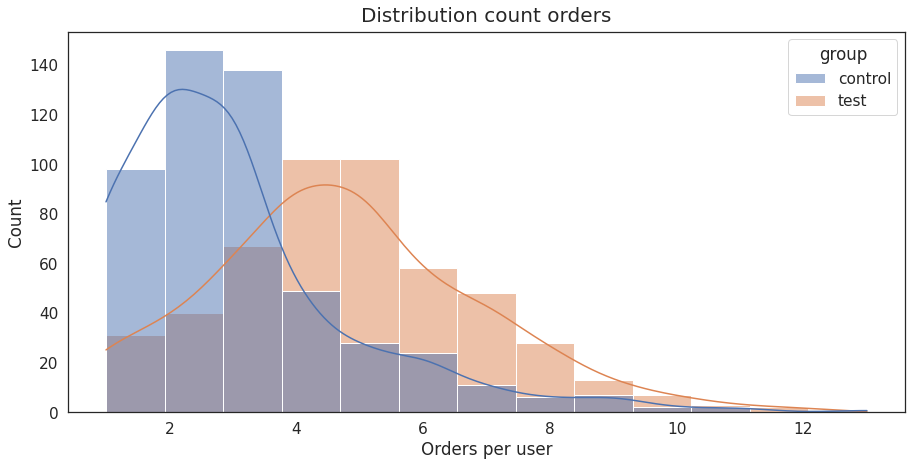

In [59]:
plt.figure(figsize=(15, 7))
sns.set(style='white', font_scale=1.4)
ax = sns.histplot(data=df_count_orders, x='order_id', hue='group', bins=13,  kde=True)
ax.set(xlabel='Orders per user')
ax.set_title('Distribution count orders', pad=10, fontsize=20)
plt.show()

In [63]:
# Требование гомогенности дисперсий по Критерию Левена не выполняется (pvalue < 0,05)

st.levene(df_count_orders.query("group == 'test'").order_id, \
          df_count_orders.query("group == 'control'").order_id)

LeveneResult(statistic=17.19594234323374, pvalue=3.654438888775981e-05)

In [64]:
# Требование к нормальности распределения в выборках (тест Агостино-Пирсона)

pg.normality(data=df_count_orders, dv='order_id', group='group', method="normaltest")

,W,pval,normal
control,178.266627,1.949368e-39,False
test,17.210719,1.831217e-04,False


**Формулировка гипотез и выбор теста**

Для исследуемой метрики параметрические предположения не выполняются, однако выборка довольна большая и отсутствуют выбросы, поэтому нормальностью распредления можно пренебречь, а различие в дисперсиях учесть при проведении тестирования → **используем T-test Уэлча**

- $H_0$: в генеральной совокупности никакого различия между средним количеством заказов на пользователя нет 
- $H_1$: в генеральной совокупности среднее количество заказов на пользователя различается

In [65]:
# T-test Уэлча (сравнение средних):

pvalue = st.ttest_ind(df_count_orders.query("group == 'test'").order_id, \
                      df_count_orders.query("group == 'control'").order_id, equal_var=False).pvalue
pvalue

1.2374101233656574e-40

Для надежности вывода проведем сравнение доверительных интервалов для средних с помощью **Bootstrap**:

In [238]:
# Бутстрап среднего (тестовая группа)

pg.compute_bootci(df_count_orders.query("group == 'test'").order_id, func='mean')

array([5.07, 5.48])

In [239]:
# Бутстрап среднего (контрольная группа)

pg.compute_bootci(df_count_orders.query("group == 'control'").order_id, func='mean')

array([3.12, 3.45])

### Вывод №2:

По результатам T-test'а отвергаем нулевую гипотезу и принимаем альтернативную (H1): **в генеральной совокупности среднее количество заказов на пользователя различается**. <br/> 

Данную альтернативную гипотезу также подтвердил проведенный bootstrap, где доверительные интервалы средних не пересекаются. По построенным гистограммам и доверительным интервалам для средних заключаем, что в тестовой группе (test) количество заказов на пользователя статистически значимо больше, чем в контрольной группе (control).

### 3. Количество продуктов в заказе

Предположим, что новая система рекомендаций может привлечь внимание покупателей к большему числу товаров т.к. она работает более эффективно. Проверим это предположение статистическим тестом.

In [72]:
df_count_product = df_users_data \
                    .query("order_id not in @canceled_orders") \
                    .merge(df_orders, on='order_id') \
                    .reset_index(drop=True)
df_count_product

,user_id,order_id,action,time,date,group,creation_time,product_ids
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,control,2022-08-26 00:00:19,"{75, 22, 53, 84}"
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,test,2022-08-26 00:02:21,"{56, 76, 39}"
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,control,2022-08-26 00:02:27,"{76, 34, 41, 38}"
3,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,test,2022-08-26 00:03:37,"{20, 45, 67, 26}"
4,968,1261,create_order,2022-08-26 00:05:35,2022-08-26,control,2022-08-26 00:05:35,"{30, 35, 69, 6}"
...,...,...,...,...,...,...,...,...
3904,990,59422,create_order,2022-09-08 23:13:03,2022-09-08,test,2022-09-08 23:13:03,"{84, 8, 24}"
3905,1418,59439,create_order,2022-09-08 23:18:05,2022-09-08,test,2022-09-08 23:18:05,"{9, 25, 75, 30, 6}"
3906,1605,59464,create_order,2022-09-08 23:22:27,2022-09-08,control,2022-09-08 23:22:27,"{60, 41, 46}"
3907,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,control,2022-09-08 23:29:06,"{9, 62, 77}"


In [73]:
# Подсчет количества товаров в заказах

df_count_product['count_products'] = df_count_product.product_ids.apply(lambda x: len(x.split(',')))
df_count_product

,user_id,order_id,action,time,date,group,creation_time,product_ids,count_products
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,control,2022-08-26 00:00:19,"{75, 22, 53, 84}",4
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,test,2022-08-26 00:02:21,"{56, 76, 39}",3
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,control,2022-08-26 00:02:27,"{76, 34, 41, 38}",4
3,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,test,2022-08-26 00:03:37,"{20, 45, 67, 26}",4
4,968,1261,create_order,2022-08-26 00:05:35,2022-08-26,control,2022-08-26 00:05:35,"{30, 35, 69, 6}",4
...,...,...,...,...,...,...,...,...,...
3904,990,59422,create_order,2022-09-08 23:13:03,2022-09-08,test,2022-09-08 23:13:03,"{84, 8, 24}",3
3905,1418,59439,create_order,2022-09-08 23:18:05,2022-09-08,test,2022-09-08 23:18:05,"{9, 25, 75, 30, 6}",5
3906,1605,59464,create_order,2022-09-08 23:22:27,2022-09-08,control,2022-09-08 23:22:27,"{60, 41, 46}",3
3907,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,control,2022-09-08 23:29:06,"{9, 62, 77}",3


In [74]:
# Размер выборки тестовой и контрольной групп

df_count_product.group.value_counts()

test       2382
control    1527
Name: group, dtype: int64

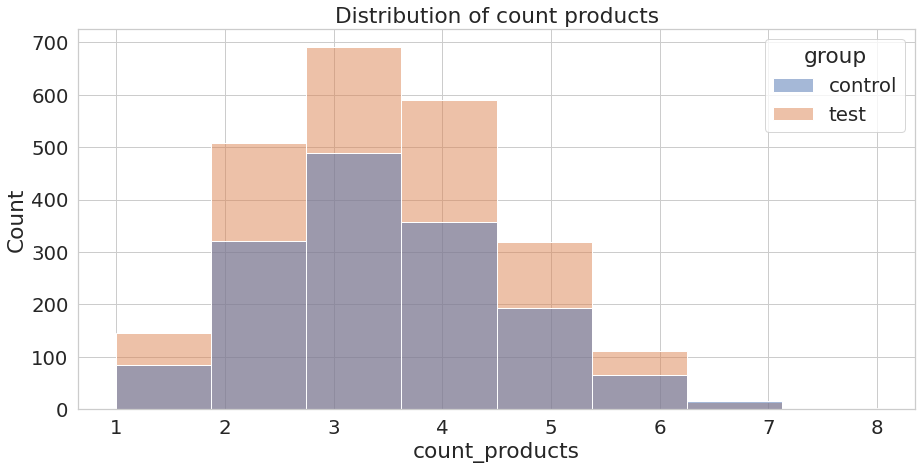

In [77]:
# Визуализация распредления количества продуктов в заказах

plt.figure(figsize=(15, 7))
sns.histplot(data=df_count_product, x='count_products', hue='group', bins=8)
plt.title('Distribution of count products')
plt.show()

In [78]:
# Требование гомогенности дисперсий по Критерию Левена выполняется (pvalue > 0,05)

st.levene(df_count_product.query("group == 'test'").count_products, \
          df_count_product.query("group == 'control'").count_products)

LeveneResult(statistic=1.787947798610625, pvalue=0.18125424676983376)

In [79]:
# Требование к нормальности распределения в выборках (тест Агостино-Пирсона)

pg.normality(data=df_count_product, dv='count_products', group='group', method="normaltest")

,W,pval,normal
control,36.287512,1.319067e-08,False
test,42.201912,6.854430e-10,False


**Формулировка гипотез и выбор теста**

Для исследуемой метрики параметрические предположения не выполняются в полной мере, однако выборка довольна большая и отсутствуют выбросы, поэтому нормальностью распредления можно пренебречь → **используем T-test Стьюдента**

- $H_0$: в генеральной совокупности никакого различия между средним количеством продуктов в заказе нет 
- $H_1$: в генеральной совокупности среднее количество продуктов в заказе различается

In [80]:
# T-test Стьюдента (сравнение средних):

pvalue = st.ttest_ind(df_count_product.query("group == 'test'").count_products, \
                      df_count_product.query("group == 'control'").count_products).pvalue
pvalue

0.84432251088501

### Вывод №3:

Результаты T-test'а не позволяют нам отклонить нулевую гипотезу (H0), следовательно, мы не можем утверждать, что новая система рекомендаций товаров приводит изменению количества продуктов в заказе. Предположение не подтвердилось.<br/> 

### 4. Средний доход с пользователя (ARPU)

Как уже известно, новая система рекомендаций привела к увеличению количества заказов у пользователей. Остается проверить привело ли это изменение к изменению дохода бизнеса. В случае, если доход увеличился, то можно предположить, что  средний чек заказов как минимум не изменился, а может даже и увеличился (что маловероятно, но система потенциально может рекомендовать товары лучшего качества по более высокой цене).

In [81]:
# Создадим список продуктов в каждом заказе

df_count_product['product_ids'] = df_count_product.product_ids.apply(lambda x: x.strip('{}').split(','))
df_count_product.head()

,user_id,order_id,action,time,date,group,creation_time,product_ids,count_products
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,control,2022-08-26 00:00:19,"[75, 22, 53, 84]",4
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,test,2022-08-26 00:02:21,"[56, 76, 39]",3
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,control,2022-08-26 00:02:27,"[76, 34, 41, 38]",4
3,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,test,2022-08-26 00:03:37,"[20, 45, 67, 26]",4
4,968,1261,create_order,2022-08-26 00:05:35,2022-08-26,control,2022-08-26 00:05:35,"[30, 35, 69, 6]",4


In [82]:
# Распакуем этот список и создадим датафрейм с информацией о товарах в заказах

df_products_info = df_count_product.explode('product_ids') \
                                   .drop(['count_products', 'creation_time'], axis=1) \
                                   .rename(columns={'product_ids':'product_id'})
df_products_info

,user_id,order_id,action,time,date,group,product_id
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,control,75
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,control,22
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,control,53
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,control,84
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,test,56
...,...,...,...,...,...,...,...
3907,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,control,9
3907,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,control,62
3907,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,control,77
3908,1376,59533,create_order,2022-09-08 23:41:24,2022-09-08,control,17


In [83]:
df_products_info['product_id'] = df_products_info.product_id.astype('int64')

In [84]:
# Датафрейм с полной информацией о товарах в заказах

df_products_info = df_products_info.merge(df_products, how='left', on='product_id')
df_products_info

,user_id,order_id,action,time,date,group,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,control,75,сок ананасовый,120.0
1,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,control,22,сок мультифрукт,120.0
2,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,control,53,мука,78.3
3,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,control,84,мандарины,90.4
4,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,test,56,сосиски,150.0
...,...,...,...,...,...,...,...,...,...
13078,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,control,9,чай черный листовой,83.5
13079,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,control,62,сок яблочный,120.0
13080,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,control,77,курица,298.4
13081,1376,59533,create_order,2022-09-08 23:41:24,2022-09-08,control,17,морс брусничный,190.0


In [85]:
# Рассчтаем доход с каждого пользователя

df_revenue = df_products_info \
    .groupby(['user_id','group'], as_index=False) \
    .agg({'price':'sum'}) \
    .round(2)
df_revenue

,user_id,group,price
0,964,control,718.9
1,965,test,4155.5
2,967,test,1137.4
3,968,control,1590.7
4,969,control,681.9
...,...,...,...
1008,1976,test,2001.9
1009,1977,test,781.2
1010,1978,test,2276.3
1011,1979,test,1907.1


In [86]:
# Размер выборки тестовой и контрольной групп

df_revenue.group.value_counts()

control    512
test       501
Name: group, dtype: int64

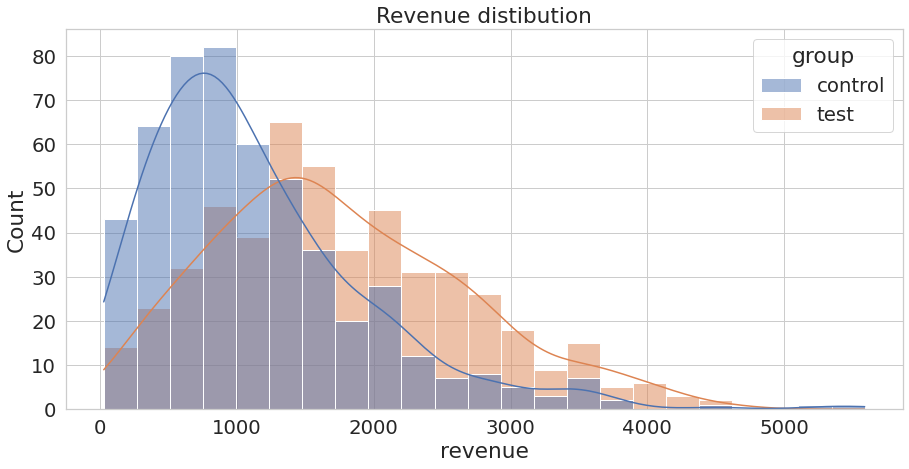

In [87]:
plt.figure(figsize=(15, 7))
bx = sns.histplot(data=df_revenue, x='price', hue='group', kde=True)
bx.set(title='Revenue distibution', xlabel='revenue')
plt.show()

In [88]:
# Требование гомогенности дисперсий по Критерию Левена не выполняется (pvalue < 0,05)

st.levene(df_revenue.query("group == 'test'").price, \
          df_revenue.query("group == 'control'").price)

LeveneResult(statistic=18.466657739438077, pvalue=1.896012459520485e-05)

In [89]:
# Требование к нормальности распределения в выборках (тест Агостино-Пирсона)

pg.normality(data=df_revenue, dv='price', group='group', method="normaltest")

,W,pval,normal
control,165.141459,1.380345e-36,False
test,21.243034,2.438562e-05,False


**Формулировка гипотез и выбор теста**

Для исследуемой метрики параметрические предположения не выполняются, однако выборка довольна большая и отсутствуют выбросы, поэтому нормальностью распредления можно пренебречь, а различие в дисперсиях учесть при проведении тестирования → **используем T-test Уэлча**

- $H_0$: в генеральной совокупности никакого различия между средним доходом с пользователя нет 
- $H_1$: в генеральной совокупности средний доход с пользователя различается

In [90]:
# T-test Уэлча (сравнение средних):

pvalue = st.ttest_ind(df_revenue.query("group == 'test'").price, \
                      df_revenue.query("group == 'control'").price, equal_var=False).pvalue
pvalue

1.5721664294812888e-27

Для надежности вывода проведем сравнение доверительных интервалов для средних с помощью **Bootstrap**:

In [91]:
# Бутстрап среднего (тестовая группа)

pg.compute_bootci(df_revenue.query("group == 'test'").price, func='mean')

array([1677.36, 1837.71])

In [92]:
# Бутстрап среднего (контрольная группа)

pg.compute_bootci(df_revenue.query("group == 'control'").price, func='mean')

array([1069.09, 1210.52])

In [93]:
# Общий доход бизнеса по группам за время тестирования

df_revenue.groupby('group').agg({'price':'sum'})

,price
group,
control,583455.9
test,878628.4


### Вывод №4:

По результатам T-test'а отвергаем нулевую гипотезу и принимаем альтернативную (H1): **в генеральной совокупности средний доход с пользователя различается**. <br/> 

Данную альтернативную гипотезу также подтвердил проведенный bootstrap, где доверительные интервалы средних не пересекаются. По построенным гистограммам и доверительным интервалам для средних заключаем, что в тестовой группе (1) доход с пользователя статистически значимо больше, чем в контрольной группе (0).<br/> 

К слову, общий доход с пользователей тестовой группы также оказался больше дохода с пользователей контрольной группы, что лишний раз подтверждает наши выводы.

## Заключение:

При использовании новой системы рекомендации товаров не обнаружено существенное изменение доли отмененных заказов и количества продуктов в заказе, однако такая система статистически значимо повышает доходность бизнеса с каждого пользователя и заинтересованность клиентов в заказах. 

**Следовательно, система считается эффективной и рекомендуется включать ее для всех пользователей.**